In [2]:
from IPython.display import display, HTML

In [3]:
display(HTML("""<div style='
    background: white;
    padding: 10px;
    color: black;
    font-weight: bold;
    font-size: 24px;
    text-align: left;'>
Section 0: Importing
</div>"""))

In [4]:
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, classification_report

from sklearn.datasets import fetch_openml 
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler

In [5]:
display(HTML("""<div style='
    background: white;
    padding: 10px;
    color: black;
    font-weight: bold;
    font-size: 24px;
    text-align: left;'>
Section 1: Data Processing
</div>"""))

In [6]:
df = pd.read_csv('data/Debernardi et al 2020 data.csv')

# remove redundant columns
df.drop(columns=['sample_id', 'benign_sample_diagnosis', 'stage', 'patient_cohort', 'sample_origin'],inplace=True)

# change gender type representation M/F to binary
label_encoder = LabelEncoder()
df['sex']= label_encoder.fit_transform(df['sex'])
df['sex']=df['sex'].astype(int)

# display current dataset
df.info()
display(df.describe())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   sex            590 non-null    int64  
 2   diagnosis      590 non-null    int64  
 3   plasma_CA19_9  350 non-null    float64
 4   creatinine     590 non-null    float64
 5   LYVE1          590 non-null    float64
 6   REG1B          590 non-null    float64
 7   TFF1           590 non-null    float64
 8   REG1A          306 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 41.6 KB


,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,590.000000,350.000000,590.000000,590.000000,590.000000,590.000000,306.000000
mean,59.079661,0.493220,2.027119,654.002944,0.855383,3.063530,111.774090,597.868722,735.281222
std,13.109520,0.500378,0.804873,2430.317642,0.639028,3.438796,196.267110,1010.477245,1477.247724
min,26.000000,0.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,0.000000,1.000000,8.000000,0.373230,0.167179,10.757216,43.961000,80.692000
50%,60.000000,0.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,1.000000,3.000000,294.000000,1.139482,5.205037,122.741013,742.736000,649.000000
max,89.000000,1.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,0,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.000
1,81,0,1,NaN,0.97266,2.037585,94.46703,209.488250,228.407
2,51,1,1,7.0,0.78039,0.145589,102.36600,461.141000,NaN
3,61,1,1,8.0,0.70122,0.002805,60.57900,142.950000,NaN
4,62,1,1,9.0,0.21489,0.000860,65.54000,41.088000,NaN


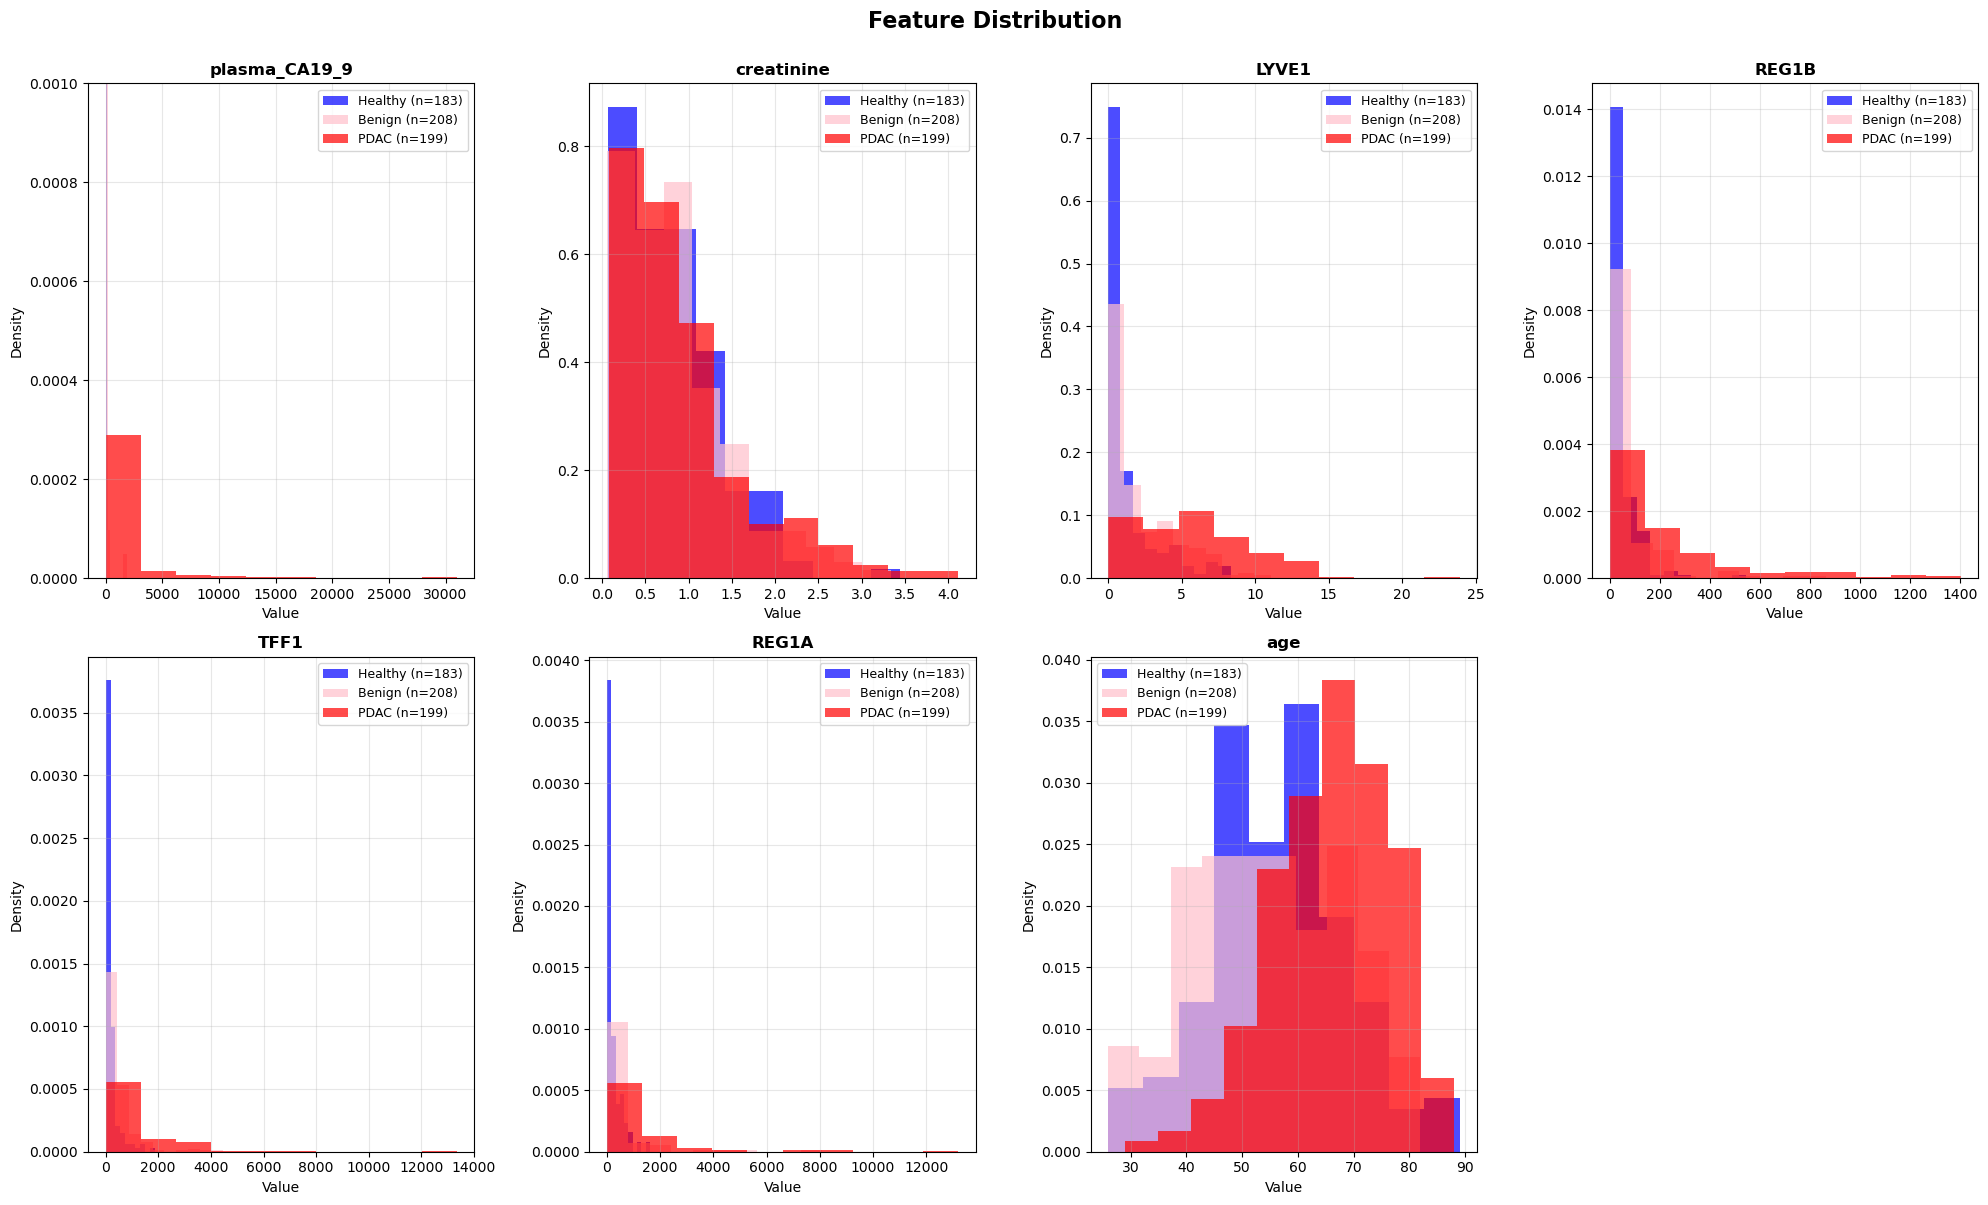

In [7]:
sns.set_palette("pastel")

features = ['plasma_CA19_9', 'creatinine', 'LYVE1', 'REG1B', 'TFF1', 'REG1A', 'age']
diagnosis_colors = {1: 'blue', 2: 'pink', 3: 'red'}
diagnosis_labels = {1: 'Healthy', 2: 'Benign', 3: 'PDAC'}

fig, axes = plt.subplots(2, 4, figsize=(20, 12))
fig.suptitle('Feature Distribution', fontsize=16, fontweight='bold', y=1)

axes = axes.flatten()

# plot histograms
for i, feature in enumerate(features):
    ax = axes[i]
    
    # for each diagnosis category
    for diagnosis in [1, 2, 3]:
        subset = df[df['diagnosis'] == diagnosis]
        ax.hist(subset[feature], alpha=0.7, 
                color=diagnosis_colors[diagnosis], 
                label=f'{diagnosis_labels[diagnosis]} (n={len(subset)})',
                density=True) 
    
    if feature == 'plasma_CA19_9':
        ax.set_ylim(0, 0.001)
        
    # style
    ax.set_title(f'{feature}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Value', fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9)

axes[7].set_visible(False)

plt.tight_layout()
plt.show()

<Figure size 1200x1000 with 0 Axes>

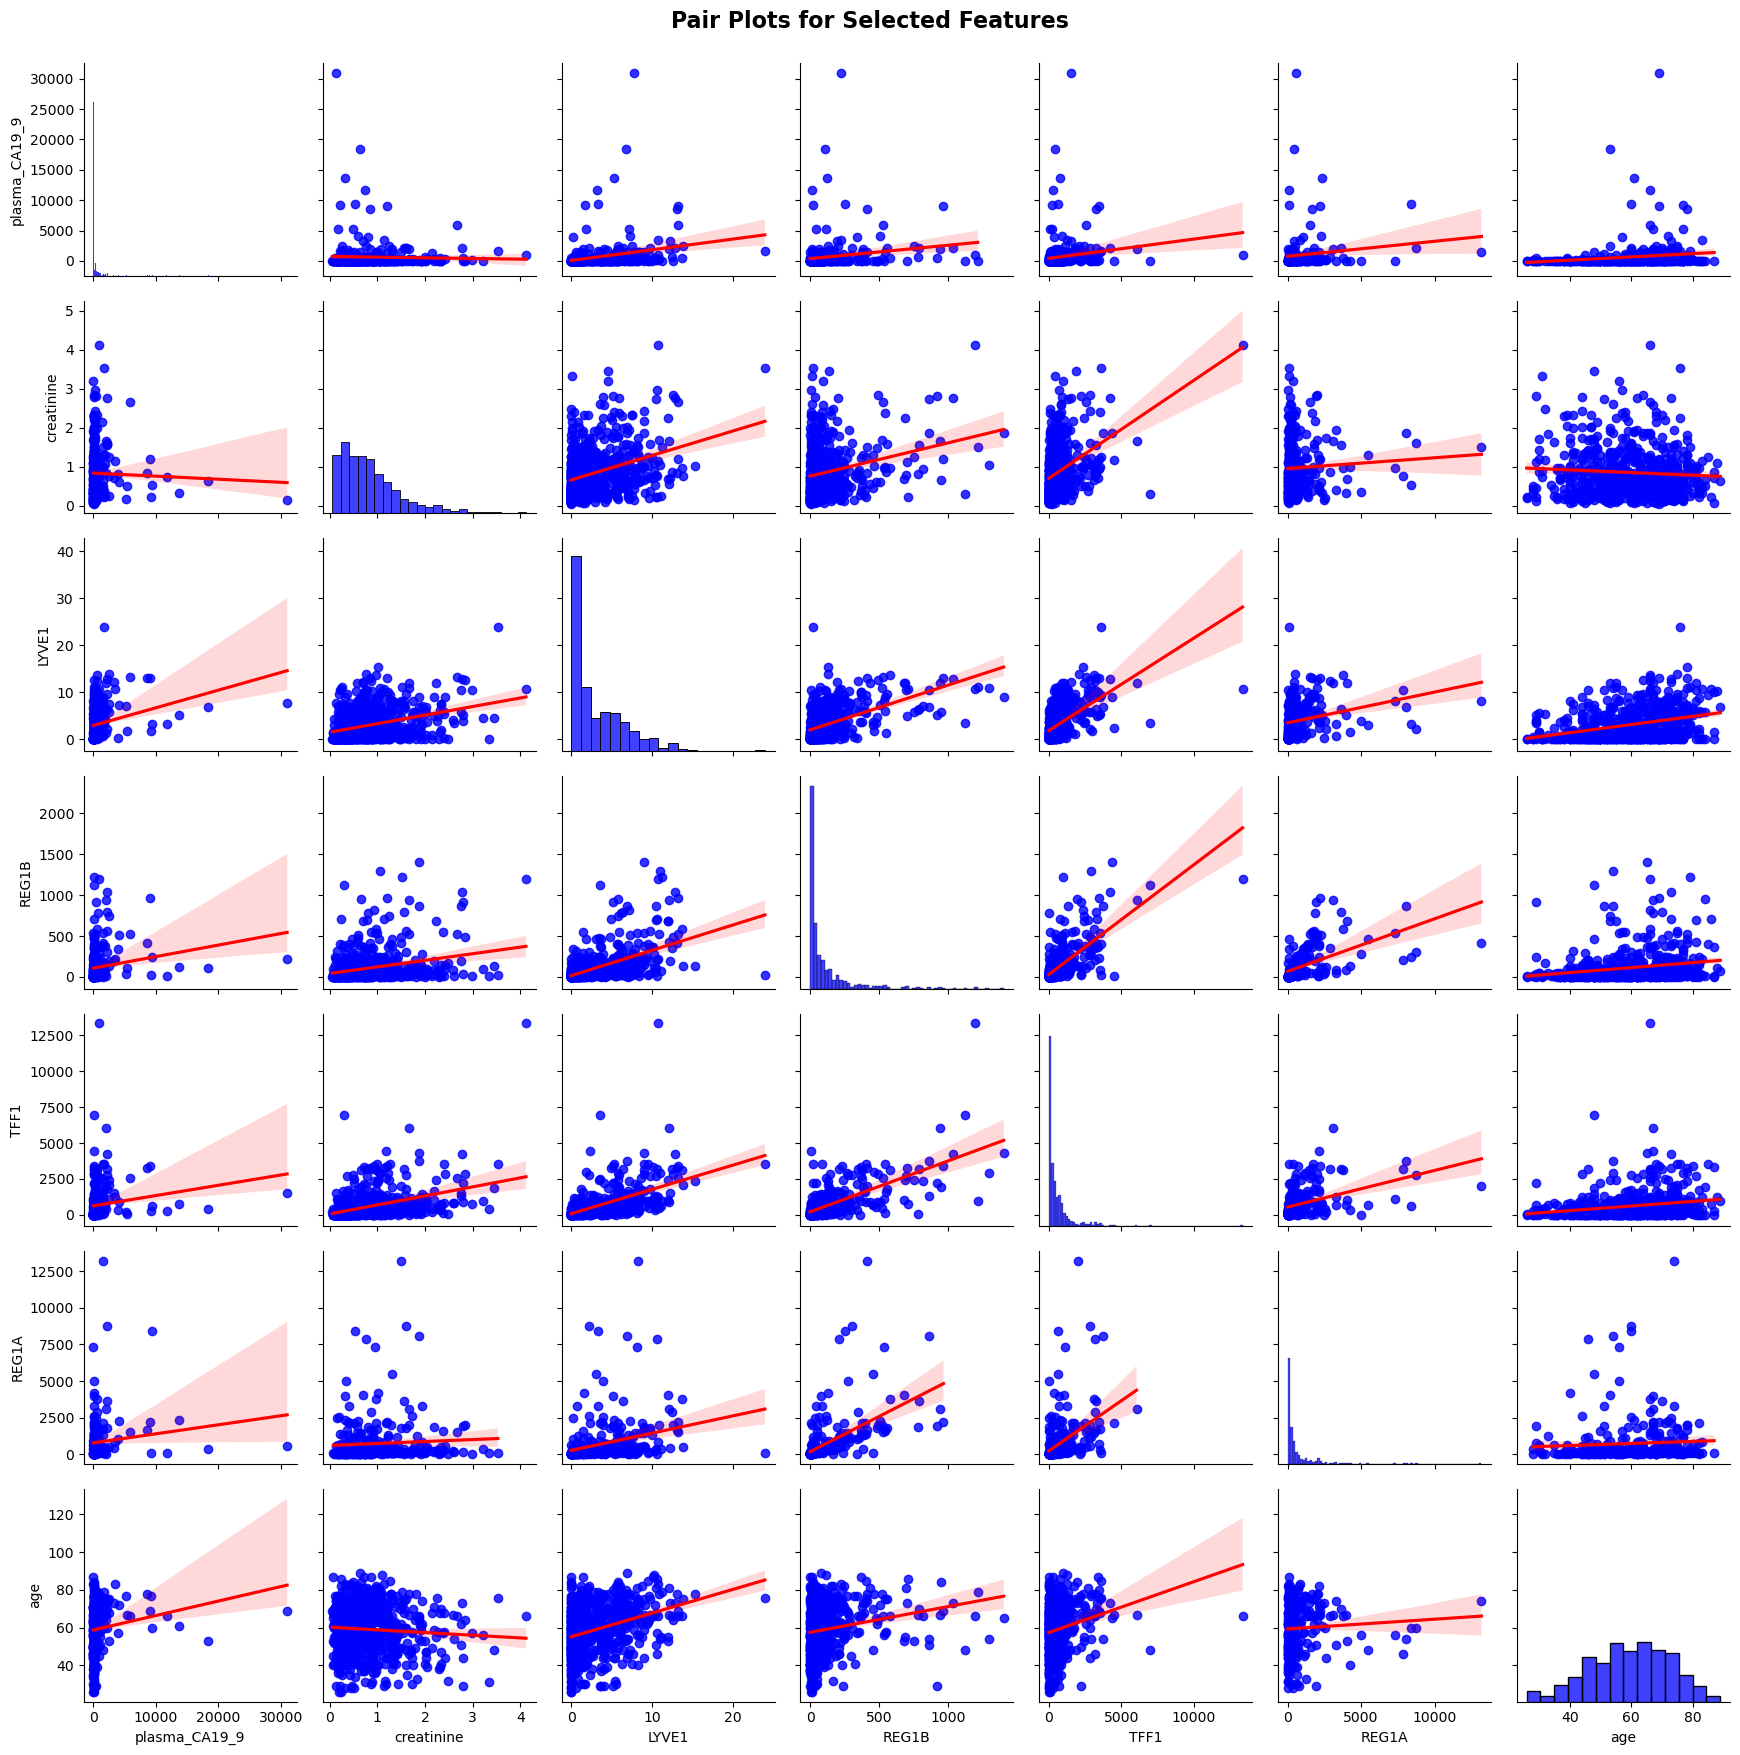

In [8]:
# pair plots
plt.figure(figsize=(12, 10))
pairplot = sns.pairplot(df[features], kind='reg', diag_kind='hist',
                        plot_kws={'scatter_kws': {'color': 'blue'},'line_kws': {'color': 'red'}},
                        diag_kws={'color': 'blue'})

pairplot.fig.suptitle('Pair Plots for Selected Features', y=1, fontsize=16, fontweight='bold',)
plt.tight_layout()
plt.show()

In [9]:
# replace missing values with the corresponding median 
# (from the plot, we see that the median is more suitable than the mean)
df['plasma_CA19_9']=df['plasma_CA19_9'].fillna(df['plasma_CA19_9'].median())
df['REG1A']=df['REG1A'].fillna(df['REG1A'].median())

# display updated dataset
df.info()
display(df.describe())
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590 entries, 0 to 589
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            590 non-null    int64  
 1   sex            590 non-null    int64  
 2   diagnosis      590 non-null    int64  
 3   plasma_CA19_9  590 non-null    float64
 4   creatinine     590 non-null    float64
 5   LYVE1          590 non-null    float64
 6   REG1B          590 non-null    float64
 7   TFF1           590 non-null    float64
 8   REG1A          590 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 41.6 KB


,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
count,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000,590.000000
mean,59.079661,0.493220,2.027119,398.747509,0.855383,3.063530,111.774090,597.868722,481.730488
std,13.109520,0.500378,0.804873,1896.028213,0.639028,3.438796,196.267110,1010.477245,1095.179818
min,26.000000,0.000000,1.000000,0.000000,0.056550,0.000129,0.001104,0.005293,0.000000
25%,50.000000,0.000000,1.000000,17.000000,0.373230,0.167179,10.757216,43.961000,195.201000
50%,60.000000,0.000000,2.000000,26.500000,0.723840,1.649862,34.303353,259.873974,208.538500
75%,69.000000,1.000000,3.000000,41.750000,1.139482,5.205037,122.741013,742.736000,224.007000
max,89.000000,1.000000,3.000000,31000.000000,4.116840,23.890323,1403.897600,13344.300000,13200.000000


,age,sex,diagnosis,plasma_CA19_9,creatinine,LYVE1,REG1B,TFF1,REG1A
0,33,0,1,11.7,1.83222,0.893219,52.94884,654.282174,1262.0000
1,81,0,1,26.5,0.97266,2.037585,94.46703,209.488250,228.4070
2,51,1,1,7.0,0.78039,0.145589,102.36600,461.141000,208.5385
3,61,1,1,8.0,0.70122,0.002805,60.57900,142.950000,208.5385
4,62,1,1,9.0,0.21489,0.000860,65.54000,41.088000,208.5385


In [10]:
X = df.drop(columns=['diagnosis']) 
y = df['diagnosis'] 

In [11]:
display(HTML("""<div style='
    background: white;
    padding: 10px;
    color: black;
    font-weight: bold;
    font-size: 24px;
    text-align: left;'>
Section 2.1: Multinomial Logistic Regression
</div>"""))

/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 1: Accuracy = 68.64%, Validation loss = 0.75, Training loss: 0.74


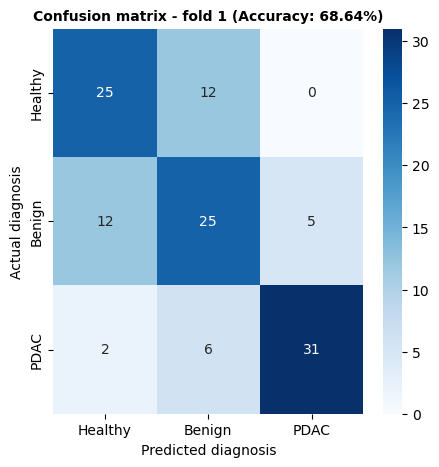

Fold 2: Accuracy = 60.17%, Validation loss = 0.77, Training loss: 0.74


/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


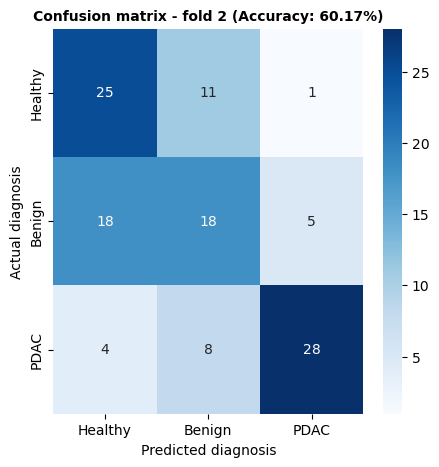

/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3: Accuracy = 55.08%, Validation loss = 0.89, Training loss: 0.71


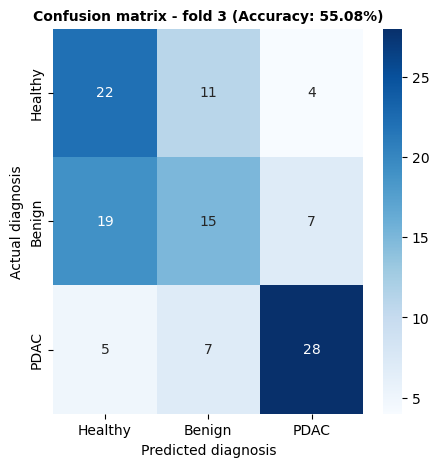

/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 4: Accuracy = 68.64%, Validation loss = 0.70, Training loss: 0.75


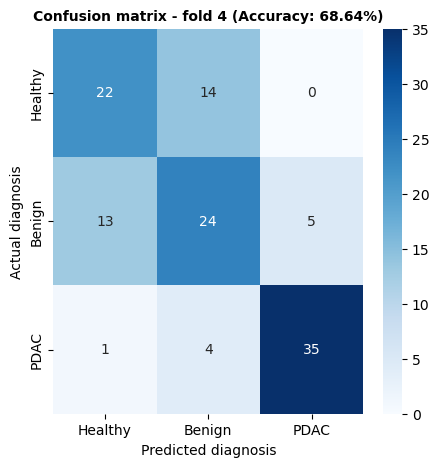

/opt/software/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 5: Accuracy = 62.71%, Validation loss = 0.73, Training loss: 0.74


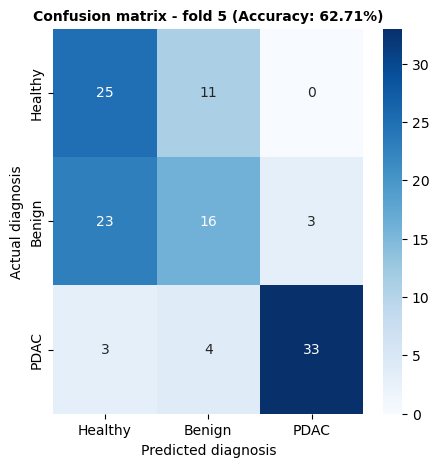

Average validation loss: 0.77
Average train loss: 0.74
Average accuracy: 63.05%


In [12]:
# Usage refers to this tutorial: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

mlr = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=42, max_iter=300000) 

val_losses = []
train_losses = []
accuracy_scores = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # training
    X_train0, X_test0 = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train0)
    X_test = scaler.transform(X_test0)

    mlr.fit(X_train, y_train)

    y_val_pred_4loss = mlr.predict_proba(X_test)
    y_train_pred_4loss = mlr.predict_proba(X_train)
    y_pred = mlr.predict(X_test)

    # evaluating
    val_loss = log_loss(y_test, y_val_pred_4loss)
    train_loss = log_loss(y_train, y_train_pred_4loss)
    accuracy = accuracy_score(y_test, y_pred)
    
    val_losses.append(val_loss)
    train_losses.append(train_loss)
    accuracy_scores.append(accuracy)
    
    # result
    print(f"Fold {i+1}: Accuracy = {accuracy*100:.2f}%, Validation loss = {val_loss:.2f}, Training loss: {train_loss:.2f}")
    
    # plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    targets = ['Healthy', 'Benign', 'PDAC']

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, cmap='Blues', 
            xticklabels=targets, yticklabels=targets)
    plt.title(f'Confusion matrix - fold {i+1} (Accuracy: {accuracy:.2%})', fontsize=10, fontweight='bold')
    plt.ylabel('Actual diagnosis', fontsize=10)
    plt.xlabel('Predicted diagnosis', fontsize=10)
    plt.show()

print(f"Average validation loss: {np.mean(val_losses):.2f}")
print(f"Average train loss: {np.mean(train_losses):.2f}")
print(f"Average accuracy: {np.mean(accuracy_scores)*100:.2f}%")

In [13]:
display(HTML("""<div style='
    background: white;
    padding: 10px;
    color: black;
    font-weight: bold;
    font-size: 24px;
    text-align: left;'>
Section 2.2: Random Forest
</div>"""))

Fold 1: Accuracy = 73.73%, Validation loss = 0.64, Training loss: 0.17
              precision    recall  f1-score   support

     Healthy       0.76      0.70      0.73        37
      Benign       0.66      0.69      0.67        42
        PDAC       0.80      0.82      0.81        39

    accuracy                           0.74       118
   macro avg       0.74      0.74      0.74       118
weighted avg       0.74      0.74      0.74       118



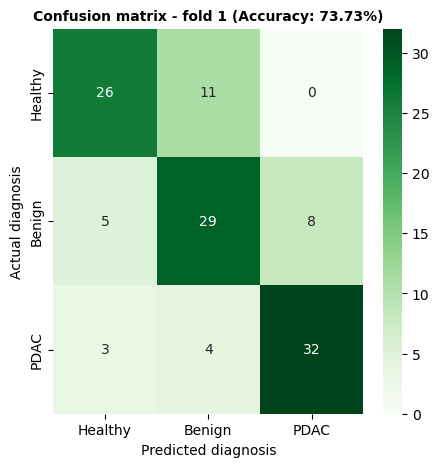

Fold 2: Accuracy = 67.80%, Validation loss = 0.65, Training loss: 0.17
              precision    recall  f1-score   support

     Healthy       0.77      0.54      0.63        37
      Benign       0.54      0.68      0.60        41
        PDAC       0.80      0.80      0.80        40

    accuracy                           0.68       118
   macro avg       0.70      0.67      0.68       118
weighted avg       0.70      0.68      0.68       118



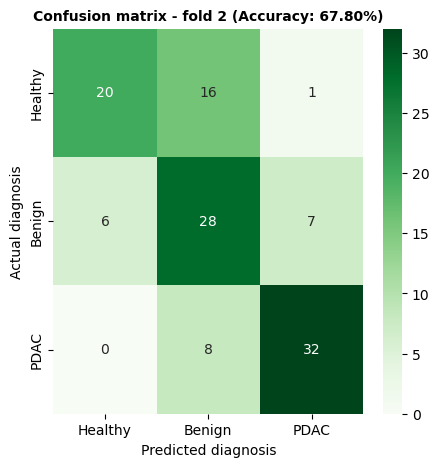

Fold 3: Accuracy = 71.19%, Validation loss = 0.69, Training loss: 0.17
              precision    recall  f1-score   support

     Healthy       0.68      0.68      0.68        37
      Benign       0.67      0.59      0.62        41
        PDAC       0.78      0.88      0.82        40

    accuracy                           0.71       118
   macro avg       0.71      0.71      0.71       118
weighted avg       0.71      0.71      0.71       118



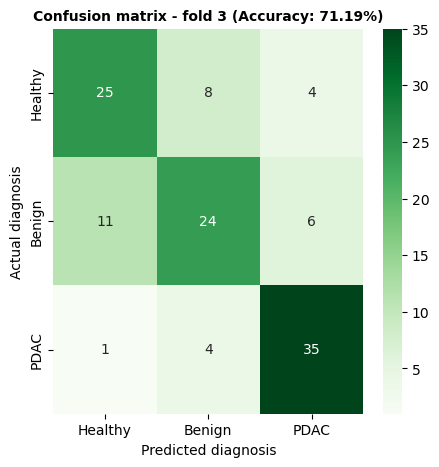

Fold 4: Accuracy = 73.73%, Validation loss = 0.58, Training loss: 0.18
              precision    recall  f1-score   support

     Healthy       0.73      0.67      0.70        36
      Benign       0.64      0.64      0.64        42
        PDAC       0.84      0.90      0.87        40

    accuracy                           0.74       118
   macro avg       0.74      0.74      0.74       118
weighted avg       0.73      0.74      0.74       118



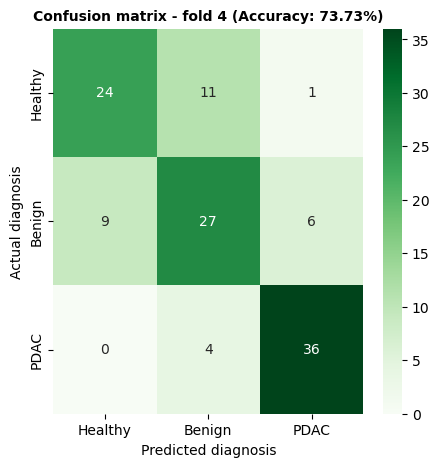

Fold 5: Accuracy = 68.64%, Validation loss = 0.66, Training loss: 0.17
              precision    recall  f1-score   support

     Healthy       0.60      0.72      0.66        36
      Benign       0.57      0.55      0.56        42
        PDAC       0.91      0.80      0.85        40

    accuracy                           0.69       118
   macro avg       0.70      0.69      0.69       118
weighted avg       0.70      0.69      0.69       118



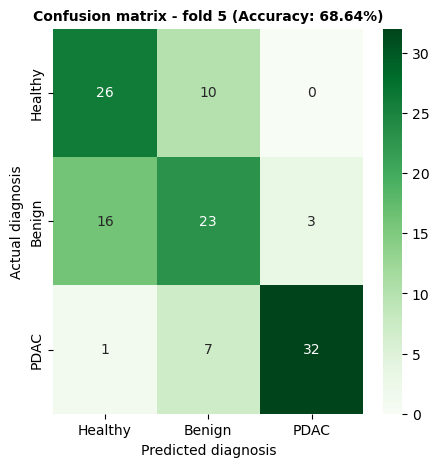

Average validation loss: 0.64
Average train loss: 0.17
Average accuracy: 71.02%


In [14]:
rf = RandomForestClassifier(n_estimators=100)

accuracy_scores_rf = []
val_losses_rf = []
train_losses_rf = []

for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    # training
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    # evaluating
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores_rf.append(accuracy)
    
    y_val_pred_4loss = rf.predict_proba(X_test)
    y_train_pred_4loss = rf.predict_proba(X_train)

    val_loss = log_loss(y_test, y_val_pred_4loss)
    train_loss = log_loss(y_train, y_train_pred_4loss)
    
    val_losses_rf.append(val_loss)
    train_losses_rf.append(train_loss)
    
    # result
    print(f"Fold {i+1}: Accuracy = {accuracy*100:.2f}%, Validation loss = {val_loss:.2f}, Training loss: {train_loss:.2f}")
    
    
    report = classification_report(y_test, y_pred, target_names=['Healthy', 'Benign', 'PDAC']) # Gini is implemented by default
    print(report)
    
    # plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    targets = ['Healthy', 'Benign', 'PDAC']

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, cmap='Greens', 
            xticklabels=targets, yticklabels=targets)
    plt.title(f'Confusion matrix - fold {i+1} (Accuracy: {accuracy:.2%})', fontsize=10, fontweight='bold')
    plt.ylabel('Actual diagnosis', fontsize=10)
    plt.xlabel('Predicted diagnosis', fontsize=10)
    plt.show()
    
    # plot comparison between predicted and real values for model with larger than 75% accuracy score. 
    if accuracy > 0.75:
        
        results_df = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred,
            'Index': y_test.index 
        })
        
        correct_preds = results_df[results_df['Actual'] == results_df['Predicted']]
        incorrect_preds = results_df[results_df['Actual'] != results_df['Predicted']]
        
        plt.figure()
        
        plt.scatter(correct_preds['Index'], correct_preds['Actual'], 
                    alpha=0.7, facecolors='none', edgecolors='green',
                    linewidths=1.5, label='Correct prediction', marker='o')
        plt.scatter(incorrect_preds['Index'], incorrect_preds['Predicted'], 
                    color='pink', alpha=1.0, label='Incorrect prediction', marker='x') 
        
        plt.yticks([1, 2, 3], targets)
        plt.ylabel('Diagnosis', fontsize=10)
        plt.xlabel('Sample index', fontsize=10)
        plt.title(f'Predicted vs. Actual values for fold {i+1} (Accuracy: {accuracy:.2%})', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

print(f"Average validation loss: {np.mean(val_losses_rf):.2f}")
print(f"Average train loss: {np.mean(train_losses_rf):.2f}")
print(f"Average accuracy: {np.mean(accuracy_scores_rf)*100:.2f}%")

In [15]:
for dropped_feature in features: 
    X_dropped = X.drop(columns=[dropped_feature])
    
    accuracy_scores_rf_test_drop = []
    losses_rf_test_drop = []

    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        # training
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_test)

        # evaluating
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_scores_rf.append(accuracy)
    
        y_val_pred_4loss = rf.predict_proba(X_test)
        val_loss = log_loss(y_test, y_val_pred_4loss)    
        losses_rf_test_drop.append(val_loss)

    print(f"When {dropped_feature} is dropped: Average loss: {np.mean(val_losses_rf):.2f}, Average accuracy: {np.mean(accuracy_scores_rf)*100:.2f}%")

When plasma_CA19_9 is dropped: Average loss: 0.64, Average accuracy: 71.78%
When creatinine is dropped: Average loss: 0.64, Average accuracy: 71.81%
When LYVE1 is dropped: Average loss: 0.64, Average accuracy: 71.74%
When REG1B is dropped: Average loss: 0.64, Average accuracy: 71.86%
When TFF1 is dropped: Average loss: 0.64, Average accuracy: 71.92%
When REG1A is dropped: Average loss: 0.64, Average accuracy: 71.67%
When age is dropped: Average loss: 0.64, Average accuracy: 71.65%


In [16]:
# From the test above, we see that all selected features have positive contribution to enhance the model performance.
# All features are remained in this final test. 

rf2 = RandomForestClassifier(n_estimators=200, max_depth=15, min_samples_split=5, min_samples_leaf=2,
                             class_weight='balanced', bootstrap=True, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Use RobustScaler for skewed data
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

rf2.fit(X_train_scaled, y_train)

y_pred = rf2.predict(X_test_scaled)
y_pred_proba = rf2.predict_proba(X_test_scaled)
y_train_pred_proba = rf2.predict_proba(X_train_scaled)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_pred)
test_loss = log_loss(y_test, y_pred_proba)
train_loss = log_loss(y_train, y_train_pred_proba)
train_accuracy = accuracy_score(y_train, rf2.predict(X_train_scaled))

# Display results
print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Training loss: {train_loss:.4f}")
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

Training accuracy: 98.09%
Training loss: 0.3105
Test accuracy: 77.12%
Test loss: 0.5581


              precision    recall  f1-score   support

     Healthy       0.75      0.73      0.74        37
      Benign       0.71      0.66      0.68        41
        PDAC       0.84      0.93      0.88        40

    accuracy                           0.77       118
   macro avg       0.77      0.77      0.77       118
weighted avg       0.77      0.77      0.77       118



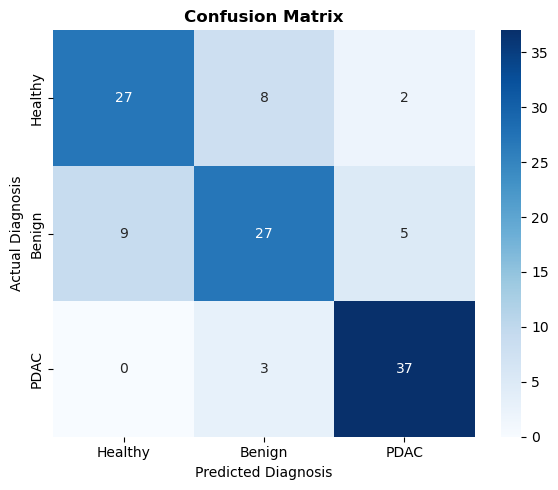

In [17]:
#report
report = classification_report(y_test, y_pred, target_names=['Healthy', 'Benign', 'PDAC'])
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
targets = ['Healthy', 'Benign', 'PDAC']

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=targets, yticklabels=targets)
plt.title(f'Confusion Matrix', fontsize=12, fontweight='bold')
plt.ylabel('Actual Diagnosis', fontsize=10)
plt.xlabel('Predicted Diagnosis', fontsize=10)
plt.tight_layout()
plt.show()

In [18]:
display(HTML("""<div style='
    background: white;
    padding: 10px;
    color: black;
    font-weight: bold;
    font-size: 24px;
    text-align: left;'>
Section 3: Dicussion: Performance with binary classification task.
</div>"""))

In [19]:
# This section perform binary classification task (0: non-cancerous, 1: cancerous) with Random Forest
# to further investigate the implementation of ML methods in this problem 

# 0: healthy or benign, 1: PDAC
y_binary = y.map({1: 0, 2: 0, 3: 1})

print('Categorical data:')
print(y.value_counts())
print('Binary data:')
print(y_binary.value_counts())

Categorical data:
diagnosis
2    208
3    199
1    183
Name: count, dtype: int64
Binary data:
diagnosis
0    391
1    199
Name: count, dtype: int64


Fold 1: Accuracy = 93.22%


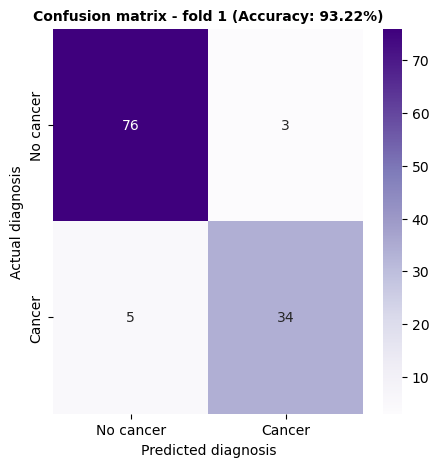

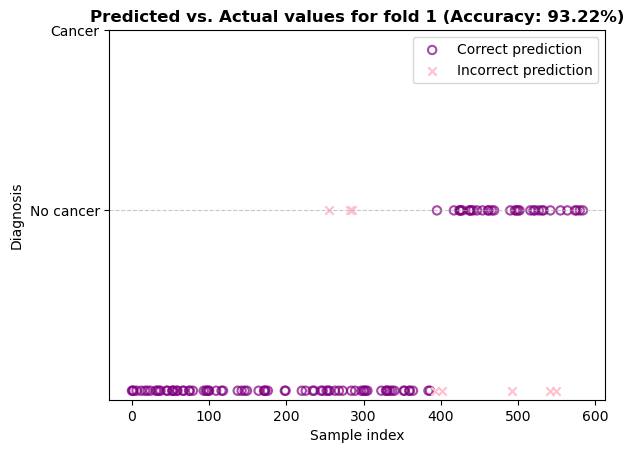

Fold 2: Accuracy = 86.44%


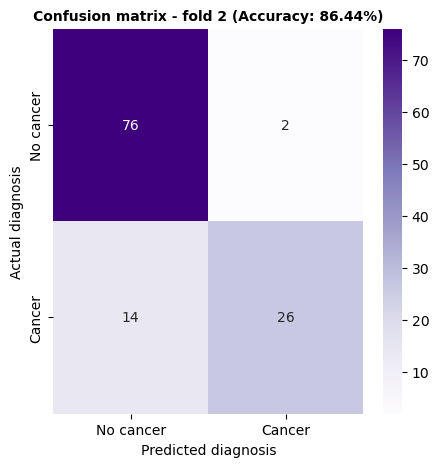

Fold 3: Accuracy = 86.44%


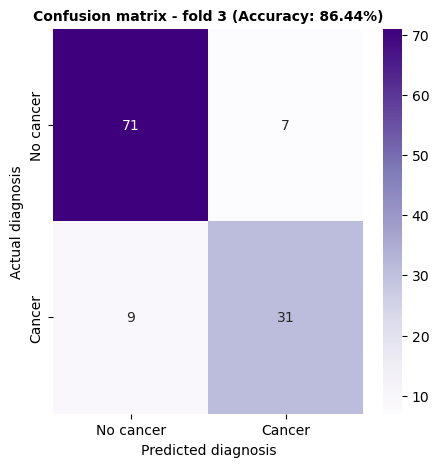

Fold 4: Accuracy = 90.68%


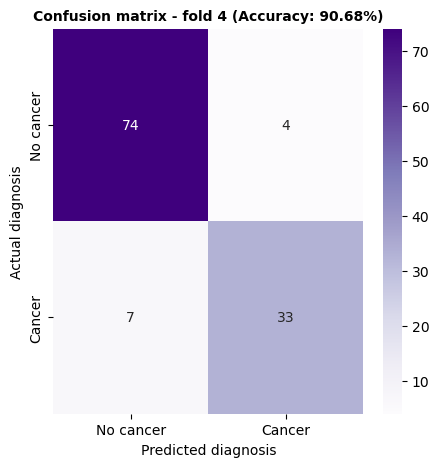

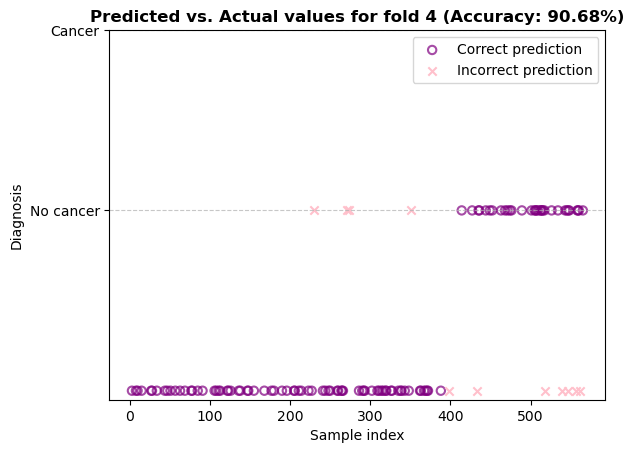

Fold 5: Accuracy = 87.29%


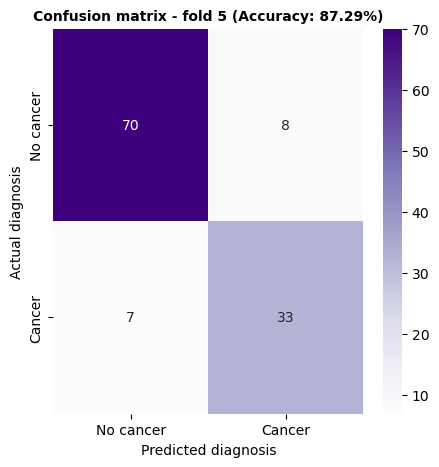

Average accuracy: 88.81%


In [20]:
accuracy_scores_rf2 = []

for i, (train_index, test_index) in enumerate(skf.split(X, y_binary)):
    # training
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y_binary.iloc[train_index], y_binary.iloc[test_index]

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)

    # evaluating
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_scores_rf2.append(accuracy)
    
    # result
    print(f"Fold {i+1}: Accuracy = {accuracy*100:.2f}%")
    
    targets = ['No cancer', 'Cancer']
    
    # plot confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(5, 5))
    sns.heatmap(conf_matrix, annot=True, cmap='Purples', 
            xticklabels=targets, yticklabels=targets)
    plt.title(f'Confusion matrix - fold {i+1} (Accuracy: {accuracy:.2%})', fontsize=10, fontweight='bold')
    plt.ylabel('Actual diagnosis', fontsize=10)
    plt.xlabel('Predicted diagnosis', fontsize=10)
    plt.show()
    
    # plot comparison between predicted and real values for model with larger than 90% accuracy score. 
    if accuracy > 0.90:
        
        results_df = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred,
            'Index': y_test.index 
        })
        
        correct_preds = results_df[results_df['Actual'] == results_df['Predicted']]
        incorrect_preds = results_df[results_df['Actual'] != results_df['Predicted']]
        
        plt.figure()
        
        plt.scatter(correct_preds['Index'], correct_preds['Actual'], 
                    alpha=0.7, facecolors='none', edgecolors='purple',
                    linewidths=1.5, label='Correct prediction', marker='o')
        plt.scatter(incorrect_preds['Index'], incorrect_preds['Predicted'], 
                    color='pink', alpha=1.0, label='Incorrect prediction', marker='x') 
        
        plt.yticks([1, 2], targets)
        plt.ylabel('Diagnosis', fontsize=10)
        plt.xlabel('Sample index', fontsize=10)
        plt.title(f'Predicted vs. Actual values for fold {i+1} (Accuracy: {accuracy:.2%})', fontsize=12, fontweight='bold')
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

print(f"Average accuracy: {np.mean(accuracy_scores_rf2)*100:.2f}%")